<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/370_PCA_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/Sr1lpMBpmVo



## Principal Component Analysis for dimensionality reduction?

### The Curse of Dimensionality
- **Visualization difficulty**: Cannot effectively plot beyond 3 dimensions
- **Computational complexity**: Algorithms become slower with more features
- **Sparse data phenomenon**: Data points become distant in high-dimensional space
- **Overfitting risk**: More features than samples can lead to poor generalization

### When PCA is Beneficial
- **Correlated features**: When features contain redundant information
- **High dimensionality**: More than 10-20 features typically benefit from reduction
- **Noise reduction**: PCA filters out less important variations
- **Visualization needs**: Reducing to 2D or 3D for plotting
- **Computational efficiency**: Speeds up machine learning algorithms

### Dataset Structure
- **569 samples** of breast tumor measurements
- **30 features** describing cell nucleus characteristics
- **10 characteristics × 3 measurement types** (mean, SE, worst)
- **Binary classification**: Malignant (0) vs Benign (1)

## What We Will Discover
- High correlation structure: 44+ feature pairs with |r| > 0.8
- Large scale differences requiring standardization
- Good sample-to-feature ratio (19:1)
- Clear class separation in individual features
- Geometric features (radius, area, perimeter) highly correlated as expected


# 1: Data Loading and High-Dimensional Data Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)



Load breast cancer dataset and create DataFrame with target labels

In [ ]:
print("Loading and Exploration of our data")
print("-" * 50)

# Load the breast cancer dataset
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
feature_names = breast_cancer.feature_names
target_names = breast_cancer.target_names

# Create DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['diagnosis'] = df['target'].map({0: 'malignant', 1: 'benign'})

print(f"Dataset shape: {df.shape}")
print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
print(f"Target distribution:\n{df['diagnosis'].value_counts()}")

Loading and Exploration of our data
--------------------------------------------------
Dataset shape: (569, 32)
Features: 30, Samples: 569
Target distribution:
diagnosis
benign       357
malignant    212
Name: count, dtype: int64


Analyze high-dimensional data characteristics (correlation, scale differences)

In [ ]:
def analyze_dimensionality(data, feature_names, target):
    """Analyze high-dimensional data characteristics."""
    n_samples, n_features = data.shape

    print(f"\nDimensionality Analysis:")
    print(f"Features: {n_features}, Samples: {n_samples}")
    print(f"Sample-to-feature ratio: {n_samples/n_features:.2f}")

    # Feature scale analysis
    feature_scales = [np.ptp(data[:, i]) for i in range(n_features)]
    scale_ratio = np.max(feature_scales) / np.min(feature_scales)

    print(f"\nFeature Scale Analysis:")
    print(f"Scale ratio (max/min): {scale_ratio:.2f}")
    if scale_ratio > 100:
        print("Large scale differences - standardization needed")

    # Correlation analysis
    corr_matrix = np.corrcoef(data.T)
    upper_triangle = np.triu(corr_matrix, k=1)
    high_corr_count = np.sum(np.abs(upper_triangle) > 0.8)
    total_pairs = (n_features * (n_features - 1)) // 2

    print(f"\nCorrelation Analysis:")
    print(f"High correlations (|r| > 0.8): {high_corr_count} ({high_corr_count/total_pairs*100:.1f}%)")

    if high_corr_count > total_pairs * 0.1:
        print("High redundancy detected - good candidate for PCA")

    return corr_matrix, scale_ratio, high_corr_count

print("\nAnalyzing high-dimensional data characteristics...")
corr_matrix, scale_ratio, high_corr_count = analyze_dimensionality(X, feature_names, y)


Analyzing high-dimensional data characteristics...

Dimensionality Analysis:
Features: 30, Samples: 569
Sample-to-feature ratio: 18.97

Feature Scale Analysis:
Scale ratio (max/min): 140569.08
Large scale differences - standardization needed

Correlation Analysis:
High correlations (|r| > 0.8): 44 (10.1%)
High redundancy detected - good candidate for PCA


Visualize data structure with correlation heatmap and feature distributions


Visualizing data structure...


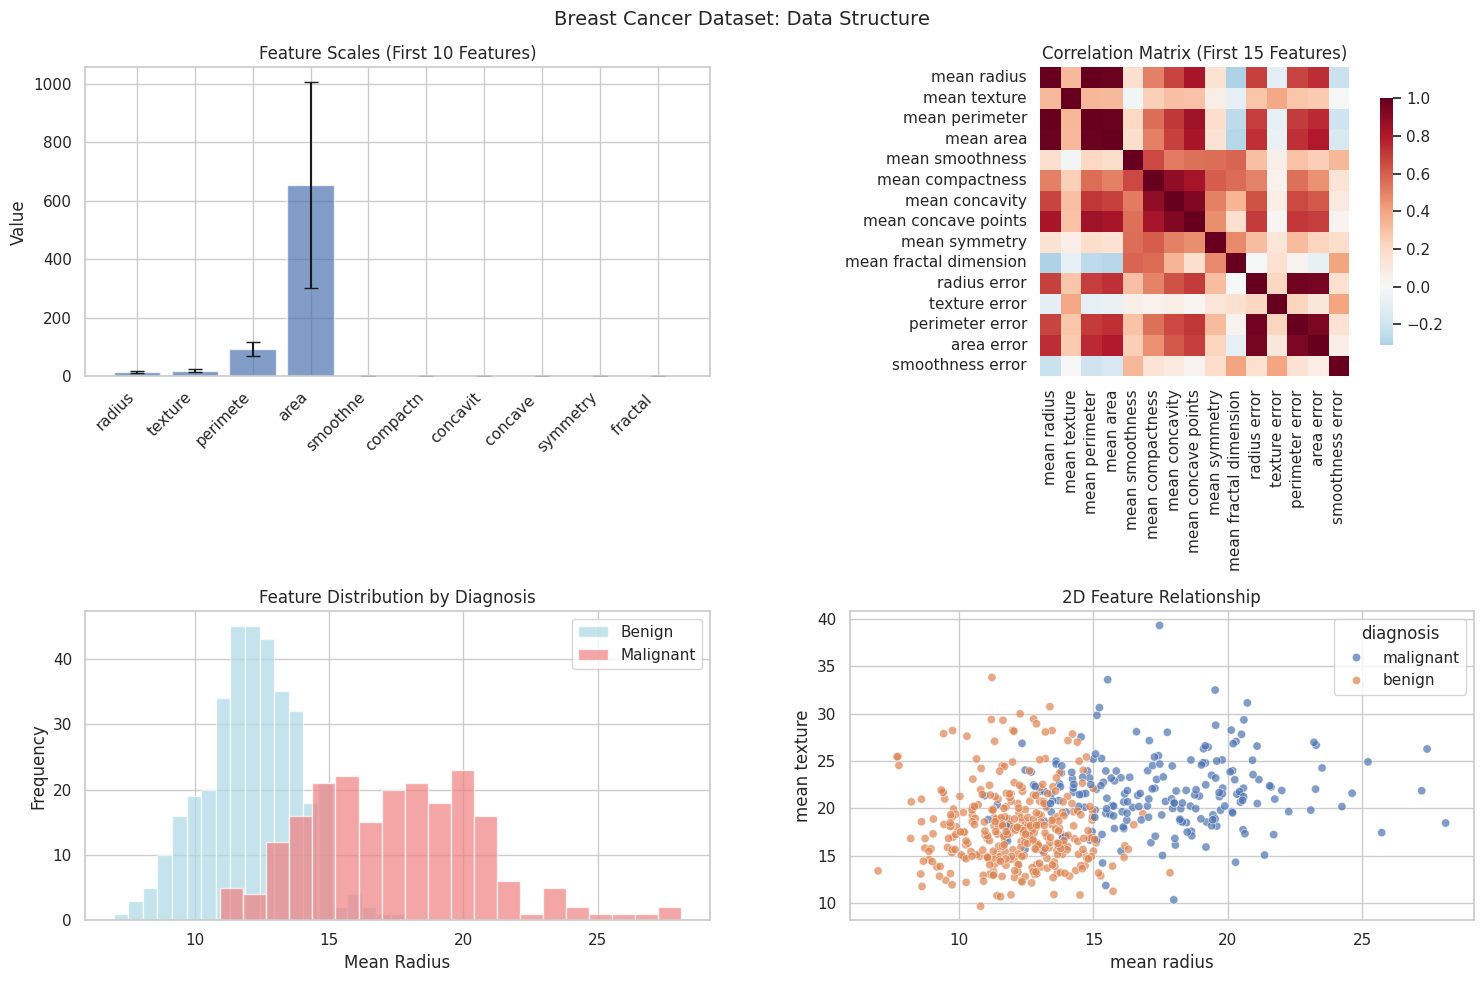

In [ ]:
def visualize_data_structure(df, feature_names):
    """Visualize basic data structure and relationships."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Breast Cancer Dataset: Data Structure', fontsize=14)

    # Feature scales (first 10 features)
    features_subset = list(feature_names[:10])
    means = [df[feat].mean() for feat in features_subset]
    stds = [df[feat].std() for feat in features_subset]

    x_pos = np.arange(len(features_subset))
    axes[0, 0].bar(x_pos, means, yerr=stds, alpha=0.7, capsize=5)
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels([name.replace('mean ', '')[:8] for name in features_subset],
                               rotation=45, ha='right')
    axes[0, 0].set_title('Feature Scales (First 10 Features)')
    axes[0, 0].set_ylabel('Value')

    # Correlation heatmap
    corr_subset = df[list(feature_names[:15])].corr()
    sns.heatmap(corr_subset, annot=False, cmap='RdBu_r', center=0,
                square=True, ax=axes[0, 1], cbar_kws={'shrink': 0.8})
    axes[0, 1].set_title('Correlation Matrix (First 15 Features)')

    # Distribution by diagnosis
    axes[1, 0].hist(df[df['diagnosis'] == 'benign']['mean radius'],
                    alpha=0.7, label='Benign', bins=20, color='lightblue')
    axes[1, 0].hist(df[df['diagnosis'] == 'malignant']['mean radius'],
                    alpha=0.7, label='Malignant', bins=20, color='lightcoral')
    axes[1, 0].set_xlabel('Mean Radius')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Feature Distribution by Diagnosis')
    axes[1, 0].legend()

    # 2D feature relationship
    sns.scatterplot(data=df, x='mean radius', y='mean texture',
                    hue='diagnosis', alpha=0.7, ax=axes[1, 1])
    axes[1, 1].set_title('2D Feature Relationship')

    plt.tight_layout()
    plt.show()

print("\nVisualizing data structure...")
visualize_data_structure(df, feature_names)

Find and display top feature correlations to identify redundancy

In [ ]:
def find_top_correlations(df, feature_names, n_top=10):
    """Find and display top correlations."""
    corr_matrix = df[list(feature_names)].corr()

    # Extract correlation pairs
    correlation_pairs = []
    for i in range(len(feature_names)):
        for j in range(i+1, len(feature_names)):
            corr_val = corr_matrix.iloc[i, j]
            correlation_pairs.append({
                'feature1': feature_names[i],
                'feature2': feature_names[j],
                'correlation': corr_val
            })

    # Sort by absolute correlation
    correlation_pairs.sort(key=lambda x: abs(x['correlation']), reverse=True)

    print(f"\nTop {n_top} Correlations:")
    for i, pair in enumerate(correlation_pairs[:n_top], 1):
        feat1 = pair['feature1'].replace('mean ', '').replace('worst ', '')[:12]
        feat2 = pair['feature2'].replace('mean ', '').replace('worst ', '')[:12]
        print(f"{i:2d}. {feat1} ↔ {feat2}: r = {pair['correlation']:6.3f}")

    return correlation_pairs

print("\nFinding feature correlations...")
top_correlations = find_top_correlations(df, feature_names)

print(f"\nSummary:")
print(f"- Dataset has {X.shape[1]} features with high correlation structure")
print(f"- {high_corr_count} feature pairs are highly correlated (|r| > 0.8)")
print(f"- Large scale differences require standardization")
print(f"- Ready for PCA analysis")



Finding feature correlations...

Top 10 Correlations:
 1. radius ↔ perimeter: r =  0.998
 2. radius ↔ perimeter: r =  0.994
 3. radius ↔ area: r =  0.987
 4. perimeter ↔ area: r =  0.987
 5. radius ↔ area: r =  0.984
 6. perimeter ↔ area: r =  0.978
 7. radius error ↔ perimeter er: r =  0.973
 8. perimeter ↔ perimeter: r =  0.970
 9. radius ↔ radius: r =  0.970
10. perimeter ↔ radius: r =  0.969

Summary:
- Dataset has 30 features with high correlation structure
- 44 feature pairs are highly correlated (|r| > 0.8)
- Large scale differences require standardization
- Ready for PCA analysis


# 2: Data Standardization and Step-by-Step PCA Implementation

## Why Standardization Matters

### The Problem with Raw Data
- PCA finds directions of **maximum variance** in data
- Features with larger scales dominate the analysis
- Example: Area values (100-2000) would overwhelm texture values (10-30)
- Result: PCA captures scale differences, not meaningful patterns

### Standardization Process
Transform each feature: **X_standardized = (X - mean) / std**
- All features get mean = 0 and standard deviation = 1
- Equal importance for all features in PCA analysis

## Mathematical Foundation of PCA

### Step 1: Data Centering
- Data already centered after standardization (mean = 0)
- Essential because PCA finds directions through origin

### Step 2: Covariance Matrix Calculation
- **Formula**: $C = \frac{1}{n - 1} X^T X$
- **Diagonal elements**: Variances of individual features
- **Off-diagonal elements**: Covariances between features
- **Property**: Always symmetric $C = C^T$

### Step 3: Eigendecomposition
- **Equation**: C × v = λ × v
- **Eigenvectors (v)**: Directions of principal components
- **Eigenvalues (λ)**: Amount of variance explained by each component
- **Ordering**: Sort eigenvalues in descending order

### Step 4: Data Transformation
- **Formula**: Y = X_centered × V
- **V**: Matrix of eigenvectors (principal component directions)
- **Y**: Data projected onto principal component space


Execute data standardization - converts all features to mean=0, std=1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def standardize_data(X, feature_names):
    """Standardize features for PCA analysis."""

    # Show scale differences before standardization
    print(f"\nBefore standardization (first 5 features):")
    for i in range(5):
        mean_val = np.mean(X[:, i])
        std_val = np.std(X[:, i])
        range_val = np.ptp(X[:, i])
        print(f"{feature_names[i][:20]:<20}: mean={mean_val:>8.2f}, std={std_val:>8.2f}, range={range_val:>8.2f}")

    # Standardize
    scaler = StandardScaler()  # Standardize features by removing the mean and scaling to unit variance.
    X_scaled = scaler.fit_transform(X)

    print(f"\nAfter standardization (same features):")
    for i in range(5):
        mean_val = np.mean(X_scaled[:, i])
        std_val = np.std(X_scaled[:, i])
        print(f"{feature_names[i][:20]:<20}: mean={mean_val:>8.3f}, std={std_val:>8.3f}")

    return X_scaled, scaler

print("=" * 60)
print("DATA STANDARDIZATION")
print("=" * 60)

# Execute standardization
X_scaled, scaler = standardize_data(X, feature_names)

print(f"Original data shape: {X.shape}")
print(f"Standardized data shape: {X_scaled.shape}")
print(f"All features now have mean ≈ 0 and std ≈ 1")

DATA STANDARDIZATION

Before standardization (first 5 features):
mean radius         : mean=   14.13, std=    3.52, range=   21.13
mean texture        : mean=   19.29, std=    4.30, range=   29.57
mean perimeter      : mean=   91.97, std=   24.28, range=  144.71
mean area           : mean=  654.89, std=  351.60, range= 2357.50
mean smoothness     : mean=    0.10, std=    0.01, range=    0.11

After standardization (same features):
mean radius         : mean=  -0.000, std=   1.000
mean texture        : mean=  -0.000, std=   1.000
mean perimeter      : mean=  -0.000, std=   1.000
mean area           : mean=  -0.000, std=   1.000
mean smoothness     : mean=   0.000, std=   1.000
Original data shape: (569, 30)
Standardized data shape: (569, 30)
All features now have mean ≈ 0 and std ≈ 1


Execute PCA mathematics - compute eigenvalues, eigenvectors, explained variance

In [ ]:
def implement_pca_step_by_step(X_scaled, feature_names):
    """Implement PCA step-by-step to understand the mathematics."""

    print(f"\nPCA Implementation Steps:")
    n_samples, n_features = X_scaled.shape
    print(f"Data dimensions: {n_samples} samples × {n_features} features")

    # Step 1: Data is already centered (standardization sets mean=0)
    print(f"\nStep 1: Data Centering")
    print("Data already centered (standardization sets mean=0)")

    # Step 2: Calculate covariance matrix
    print(f"\nStep 2: Covariance Matrix")
    cov_matrix = np.cov(X_scaled.T)
    print(f"Covariance matrix shape: {cov_matrix.shape}")
    print(f"Matrix is symmetric: {np.allclose(cov_matrix, cov_matrix.T)}")

    # Step 3: Eigendecomposition
    print(f"\nStep 3: Eigendecomposition")
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    print(f"Eigenvalues sum: {np.sum(eigenvalues):.2f}")
    print(f"Expected sum (number of features): {n_features}")

    # Step 4: Calculate explained variance
    print(f"\nStep 4: Variance Explained")
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    cumulative_variance = np.cumsum(explained_variance_ratio)

    print("Top 10 Principal Components:")
    print("PC    Eigenvalue   Var Explained   Cumulative")
    print("-" * 45)
    for i in range(min(10, len(eigenvalues))):
        print(f"{i+1:2d}    {eigenvalues[i]:8.3f}      {explained_variance_ratio[i]:6.3f}      {cumulative_variance[i]:6.3f}")

    # Components needed for variance thresholds
    thresholds = [0.8, 0.9, 0.95]
    print(f"\nComponents needed for variance thresholds:")
    for threshold in thresholds:
        n_components = np.argmax(cumulative_variance >= threshold) + 1
        print(f"{threshold*100:2.0f}% variance: {n_components:2d} components")

    # Step 5: Transform data
    print(f"\nStep 5: Data Transformation")
    X_pca = X_scaled @ eigenvectors
    print(f"Original shape: {X_scaled.shape}")
    print(f"Transformed shape: {X_pca.shape}")

    return {
        'eigenvalues': eigenvalues,
        'eigenvectors': eigenvectors,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance': cumulative_variance,
        'X_pca': X_pca,
        'cov_matrix': cov_matrix
    }

print("\n" + "=" * 60)
print("PCA MATHEMATICAL IMPLEMENTATION")
print("=" * 60)

# Execute PCA step-by-step
pca_results = implement_pca_step_by_step(X_scaled, feature_names)



PCA MATHEMATICAL IMPLEMENTATION

PCA Implementation Steps:
Data dimensions: 569 samples × 30 features

Step 1: Data Centering
Data already centered (standardization sets mean=0)

Step 2: Covariance Matrix
Covariance matrix shape: (30, 30)
Matrix is symmetric: True

Step 3: Eigendecomposition
Eigenvalues sum: 30.05
Expected sum (number of features): 30

Step 4: Variance Explained
Top 10 Principal Components:
PC    Eigenvalue   Var Explained   Cumulative
---------------------------------------------
 1      13.305       0.443       0.443
 2       5.701       0.190       0.632
 3       2.823       0.094       0.726
 4       1.984       0.066       0.792
 5       1.652       0.055       0.847
 6       1.209       0.040       0.888
 7       0.676       0.023       0.910
 8       0.477       0.016       0.926
 9       0.418       0.014       0.940
10       0.351       0.012       0.952

Components needed for variance thresholds:
80% variance:  5 components
90% variance:  7 components
95% va

Execute component interpretation - understand what each PC represents

Note: Loadings are the weights that show how much each original feature contributes to a principal component.

- High absolute value (like -0.261) = This feature is VERY important for this PC
- Low absolute value (like -0.05) = This feature barely matters for this PC
- Positive loading = Feature increases as PC increases
- Negative loading = Feature decreases as PC increases

In [ ]:
def analyze_components(pca_results, feature_names, n_components=3):
    """Analyze and interpret principal components."""
    print(f"\nPrincipal Component Analysis:")

    eigenvectors = pca_results['eigenvectors']
    eigenvalues = pca_results['eigenvalues']
    explained_variance_ratio = pca_results['explained_variance_ratio']

    for pc in range(n_components):
        print(f"\nPRINCIPAL COMPONENT {pc + 1}:")
        print(f"Eigenvalue: {eigenvalues[pc]:.3f}")
        print(f"Variance explained: {explained_variance_ratio[pc]:.3f} ({explained_variance_ratio[pc]*100:.1f}%)")

        # Get loadings (feature contributions)
        loadings = eigenvectors[:, pc]   # Loadings are the weights that show how much each original feature contributes to a principal component.

        # Sort features by absolute loading
        loading_pairs = [(feature_names[i], loadings[i]) for i in range(len(feature_names))]
        loading_pairs.sort(key=lambda x: abs(x[1]), reverse=True)

        print(f"Top contributing features:")
        print("Feature                 Loading")
        print("-" * 35)
        for i, (feature, loading) in enumerate(loading_pairs[:6]):
            direction = "+" if loading > 0 else "-"
            print(f"{feature[:20]:<20} {direction}{abs(loading):6.3f}")

print("\n" + "=" * 60)
print("COMPONENT INTERPRETATION")
print("=" * 60)

# Analyze the first 3 components in detail
analyze_components(pca_results, feature_names, n_components=3)



COMPONENT INTERPRETATION

Principal Component Analysis:

PRINCIPAL COMPONENT 1:
Eigenvalue: 13.305
Variance explained: 0.443 (44.3%)
Top contributing features:
Feature                 Loading
-----------------------------------
mean concave points  - 0.261
mean concavity       - 0.258
worst concave points - 0.251
mean compactness     - 0.239
worst perimeter      - 0.237
worst concavity      - 0.229

PRINCIPAL COMPONENT 2:
Eigenvalue: 5.701
Variance explained: 0.190 (19.0%)
Top contributing features:
Feature                 Loading
-----------------------------------
mean fractal dimensi + 0.367
fractal dimension er + 0.280
worst fractal dimens + 0.275
mean radius          - 0.234
compactness error    + 0.233
mean area            - 0.231

PRINCIPAL COMPONENT 3:
Eigenvalue: 2.823
Variance explained: 0.094 (9.4%)
Top contributing features:
Feature                 Loading
-----------------------------------
texture error        - 0.375
smoothness error     - 0.309
symmetry error       - 0

Comprehensive PCA visualization (scree plot, cumulative variance, 2D projection, loadings heatmap)


PCA VISUALIZATION

Creating PCA visualizations...


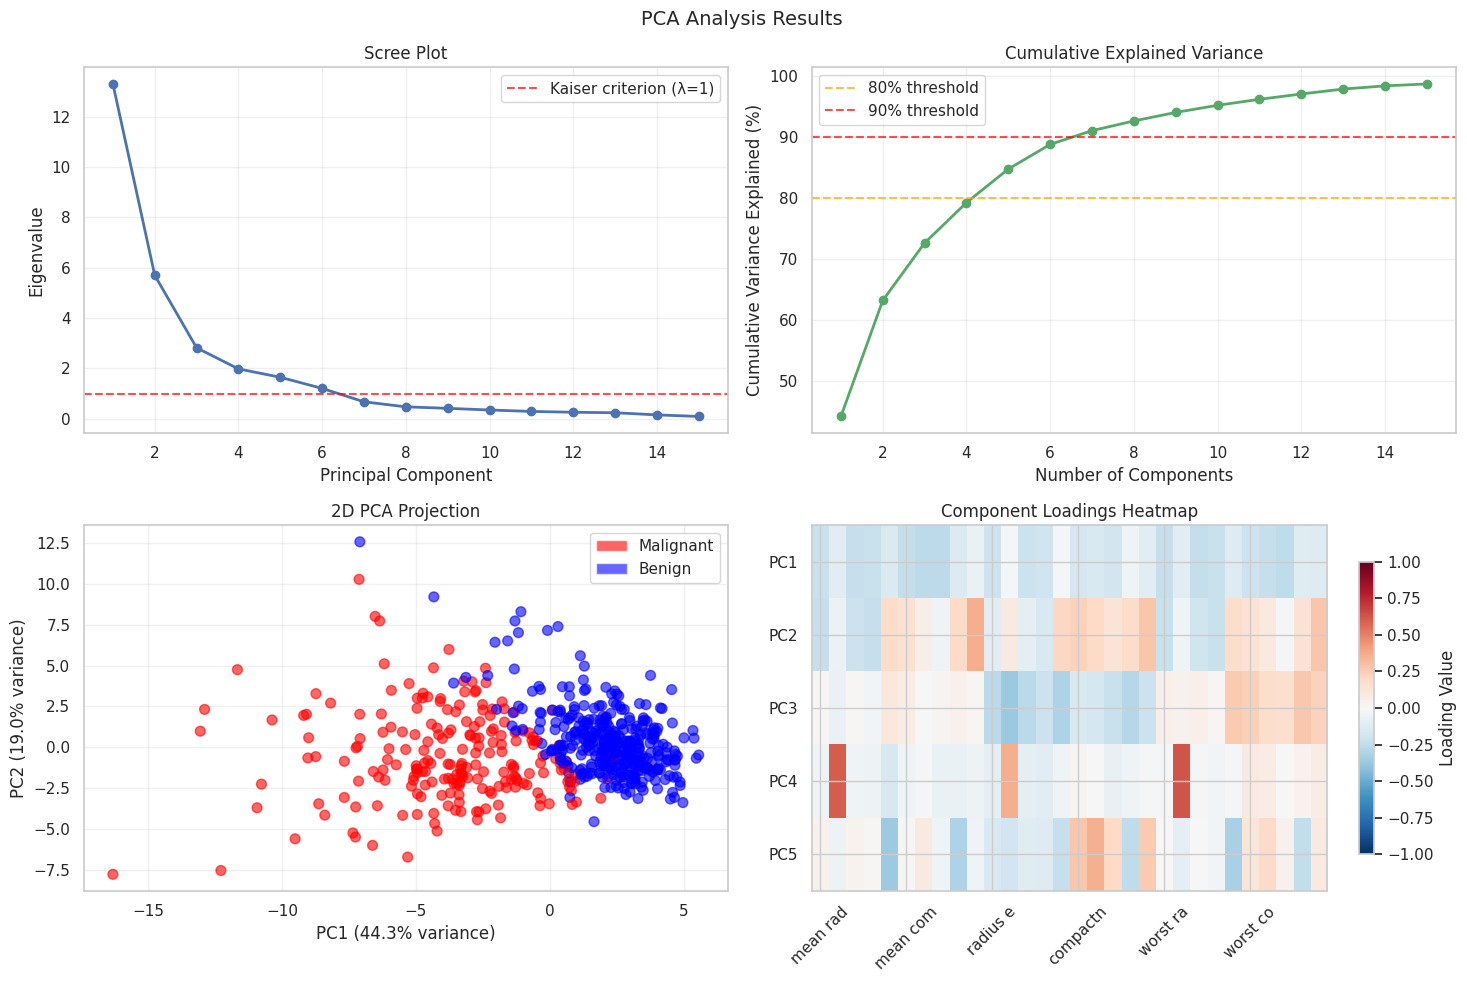


Key Insights:
- 5 components explain 80% of variance
- 7 components explain 90% of variance
- First 2 components explain 63.2% of variance
- Good class separation visible in 2D projection


In [ ]:
def visualize_pca_results(pca_results, feature_names, y, target_names):
    """Create visualizations of PCA results."""
    print(f"\nCreating PCA visualizations...")

    eigenvalues = pca_results['eigenvalues']
    explained_variance_ratio = pca_results['explained_variance_ratio']
    cumulative_variance = pca_results['cumulative_variance']
    X_pca = pca_results['X_pca']
    eigenvectors = pca_results['eigenvectors']

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('PCA Analysis Results', fontsize=14)

    # Plot 1: Scree plot
    n_components = min(15, len(eigenvalues))
    axes[0, 0].plot(range(1, n_components + 1), eigenvalues[:n_components], 'bo-', linewidth=2)
    axes[0, 0].axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Kaiser criterion (λ=1)')
    axes[0, 0].set_xlabel('Principal Component')
    axes[0, 0].set_ylabel('Eigenvalue')
    axes[0, 0].set_title('Scree Plot')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()

    # Plot 2: Cumulative explained variance
    axes[0, 1].plot(range(1, n_components + 1), cumulative_variance[:n_components] * 100, 'go-', linewidth=2)
    axes[0, 1].axhline(y=80, color='orange', linestyle='--', alpha=0.7, label='80% threshold')
    axes[0, 1].axhline(y=90, color='red', linestyle='--', alpha=0.7, label='90% threshold')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Cumulative Variance Explained (%)')
    axes[0, 1].set_title('Cumulative Explained Variance')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()

    # Plot 3: 2D PCA scatter plot
    colors = ['red' if label == 0 else 'blue' for label in y]
    scatter = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6, s=50)
    axes[1, 0].set_xlabel(f'PC1 ({explained_variance_ratio[0]*100:.1f}% variance)')
    axes[1, 0].set_ylabel(f'PC2 ({explained_variance_ratio[1]*100:.1f}% variance)')
    axes[1, 0].set_title('2D PCA Projection')
    axes[1, 0].grid(True, alpha=0.3)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', alpha=0.6, label='Malignant'),
                      Patch(facecolor='blue', alpha=0.6, label='Benign')]
    axes[1, 0].legend(handles=legend_elements)

    # Plot 4: Component loadings heatmap
    n_pcs_heatmap = 5
    loadings_matrix = eigenvectors[:, :n_pcs_heatmap]

    im = axes[1, 1].imshow(loadings_matrix.T, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    axes[1, 1].set_yticks(range(n_pcs_heatmap))
    axes[1, 1].set_yticklabels([f'PC{i+1}' for i in range(n_pcs_heatmap)])
    axes[1, 1].set_xticks(range(0, len(feature_names), 5))
    axes[1, 1].set_xticklabels([feature_names[i][:8] for i in range(0, len(feature_names), 5)], rotation=45)
    axes[1, 1].set_title('Component Loadings Heatmap')

    plt.colorbar(im, ax=axes[1, 1], shrink=0.8, label='Loading Value')
    plt.tight_layout()
    plt.show()

    # Print key insights
    pc_80 = np.argmax(cumulative_variance >= 0.8) + 1
    pc_90 = np.argmax(cumulative_variance >= 0.9) + 1
    print(f"\nKey Insights:")
    print(f"- {pc_80} components explain 80% of variance")
    print(f"- {pc_90} components explain 90% of variance")
    print(f"- First 2 components explain {cumulative_variance[1]*100:.1f}% of variance")
    print(f"- Good class separation visible in 2D projection")

    return pc_80, pc_90

print("\n" + "=" * 60)
print("PCA VISUALIZATION")
print("=" * 60)

# Create all PCA visualizations
pc_80, pc_90 = visualize_pca_results(pca_results, feature_names, y, target_names)


# 3: Component Selection, 3D Visualization, and Quality Assessment

## Component Selection Methods

### Method 1: Variance Threshold
- **Concept**: Choose components explaining target percentage of variance
- **Common thresholds**: 80%, 90%, 95%
- **Advantage**: Direct control over information retention
- **Our results**: 5 components for 80%, 7 for 90%, 10 for 95%

### Method 2: Kaiser Criterion
- **Rule**: Keep components with eigenvalues > 1
- **Logic**: Component should explain more variance than single original feature
- **Advantage**: Objective, no arbitrary threshold
- **Our results**: 6 components meet this criterion

### Method 3: Scree Plot Analysis
- **Visual method**: Plot eigenvalues and look for "elbow"
- **Elbow point**: Where eigenvalues level off
- **Interpretation**: Components before elbow are important
- **Our results**: Elbow suggests 2-3 components

### Method 4: Interpretability
- **Subjective assessment**: Can you meaningfully interpret components?
- **Consider**: Biological plausibility and clear loading patterns
- **Balance**: Statistical criteria with domain knowledge
- **Our results**: First 5 components have clear interpretations

## Advanced Visualization Techniques

### 3D PCA Projection
- **Purpose**: Visualize class separation in three most important dimensions
- **Benefits**: Shows clustering patterns and outliers
- **Our results**: Excellent class separation visible in 3D space

### Biplot Analysis
- **Combines**: Sample scores (where observations plot) + feature loadings (arrows)
- **Arrow length**: Importance of original feature in PC space
- **Arrow direction**: Positive/negative contribution to PCs
- **Interpretation**: Features pointing same direction are correlated

## Quality Assessment Metrics

### Reconstruction Error
- **Definition**: Difference between original and reconstructed data
- **Formula**: ||X_original - X_reconstructed||²
- **Trade-off**: More components = lower error but less reduction

### Effective Dimensionality
- **Concept**: True dimensionality considering eigenvalue distribution
- **Our results**: 6.6 effective dimensions (4.5x reduction possible)

### Condition Number
- **Definition**: Ratio of largest to smallest eigenvalue
- **Indicates**: Numerical stability of computation
- **Our results**: 10^5 indicates excellent stability


Component selection (4 methods: variance threshold, Kaiser, scree plot, interpretability)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print("PCA Tutorial - Part 3: Component Selection and Quality Assessment")
print("-" * 65)

def select_optimal_components(pca_results, variance_thresholds=[0.8, 0.9, 0.95]):
    """Determine optimal number of components using multiple criteria."""
    print("Component Selection Methods:")

    eigenvalues = pca_results['eigenvalues']
    explained_variance_ratio = pca_results['explained_variance_ratio']
    cumulative_variance = pca_results['cumulative_variance']

    recommendations = {}

    # Method 1: Variance threshold
    print("\n1. Variance Threshold Method:")
    for threshold in variance_thresholds:
        n_components = np.argmax(cumulative_variance >= threshold) + 1
        recommendations[f'{threshold*100:.0f}% variance'] = n_components
        print(f"   {threshold*100:3.0f}% variance: {n_components:2d} components")

    # Method 2: Kaiser criterion (eigenvalues > 1)
    print("\n2. Kaiser Criterion (eigenvalue > 1):")
    kaiser_components = np.sum(eigenvalues > 1)
    recommendations['Kaiser criterion'] = kaiser_components
    print(f"   Components with eigenvalue > 1: {kaiser_components}")

    # Method 3: Scree plot elbow
    print("\n3. Scree Plot Elbow:")
    # Simple elbow detection
    second_differences = np.diff(np.diff(eigenvalues))
    elbow_idx = np.argmax(second_differences) + 2
    recommendations['Scree plot'] = elbow_idx
    print(f"   Elbow point suggests: {elbow_idx} components")

    # Method 4: Interpretability (subjective)
    interpretable_components = 5  # Based on clear loading patterns
    recommendations['Interpretability'] = interpretable_components
    print(f"\n4. Interpretability Assessment: {interpretable_components} components")

    # Summary
    print(f"\nMethod Summary:")
    print("Method               Components   Variance Retained")
    print("-" * 50)
    for method, n_comp in recommendations.items():
        variance = cumulative_variance[n_comp-1] * 100
        print(f"{method:<20} {n_comp:6d}        {variance:6.1f}%")

    # Final recommendation
    recommended = int(np.median(list(recommendations.values())))
    print(f"\nRecommended: {recommended} components")
    print(f"Balances variance retention ({cumulative_variance[recommended-1]*100:.1f}%) with interpretability")

    return {
        'recommendations': recommendations,
        'final_recommendation': recommended,
        'variance_at_recommendation': cumulative_variance[recommended-1]
    }

print("\n" + "=" * 60)
print("OPTIMAL COMPONENT SELECTION")
print("=" * 60)

# Analyze different methods for selecting optimal number of components
selection_results = select_optimal_components(pca_results)

print(f"\nComponent selection completed!")
print(f"Final recommendation: {selection_results['final_recommendation']} components")
print(f"This retains {selection_results['variance_at_recommendation']*100:.1f}% of variance")
print(f"Selection methods used: Variance threshold, Kaiser, Scree plot, Interpretability")

PCA Tutorial - Part 3: Component Selection and Quality Assessment
-----------------------------------------------------------------

OPTIMAL COMPONENT SELECTION
Component Selection Methods:

1. Variance Threshold Method:
    80% variance:  5 components
    90% variance:  7 components
    95% variance: 10 components

2. Kaiser Criterion (eigenvalue > 1):
   Components with eigenvalue > 1: 6

3. Scree Plot Elbow:
   Elbow point suggests: 2 components

4. Interpretability Assessment: 5 components

Method Summary:
Method               Components   Variance Retained
--------------------------------------------------
80% variance              5          84.7%
90% variance              7          91.0%
95% variance             10          95.2%
Kaiser criterion          6          88.8%
Scree plot                2          63.2%
Interpretability          5          84.7%

Recommended: 5 components
Balances variance retention (84.7%) with interpretability

Component selection completed!
Final 

3D visualization for first three principal components


3D PCA VISUALIZATION

Creating 3D PCA visualization...


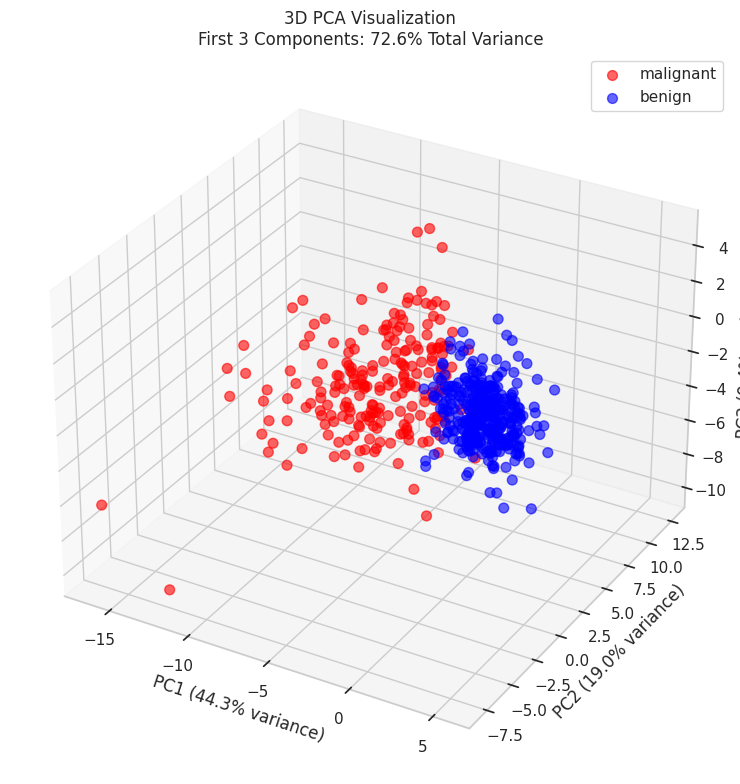

3D Insights:
- First 3 components explain 72.6% of variance
- Clear class separation visible in 3D space
- PC1 provides primary separation axis


In [ ]:
def create_3d_visualization(pca_results, y, target_names):
    """Create 3D visualization of first three principal components."""
    print("\nCreating 3D PCA visualization...")

    X_pca = pca_results['X_pca']
    explained_variance_ratio = pca_results['explained_variance_ratio']

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Color points by class
    colors = ['red', 'blue']
    for i, target in enumerate(np.unique(y)):
        mask = y == target
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
                  c=colors[i], label=target_names[target], alpha=0.6, s=50)

    ax.set_xlabel(f'PC1 ({explained_variance_ratio[0]*100:.1f}% variance)')
    ax.set_ylabel(f'PC2 ({explained_variance_ratio[1]*100:.1f}% variance)')
    ax.set_zlabel(f'PC3 ({explained_variance_ratio[2]*100:.1f}% variance)')
    ax.set_title(f'3D PCA Visualization\nFirst 3 Components: {sum(explained_variance_ratio[:3])*100:.1f}% Total Variance')
    ax.legend()

    plt.tight_layout()
    plt.show()

    print(f"3D Insights:")
    print(f"- First 3 components explain {sum(explained_variance_ratio[:3])*100:.1f}% of variance")
    print(f"- Clear class separation visible in 3D space")
    print(f"- PC1 provides primary separation axis")

    return sum(explained_variance_ratio[:3])

print("\n" + "=" * 60)
print("3D PCA VISUALIZATION")
print("=" * 60)

# Create 3D visualization of first three components
variance_3d = create_3d_visualization(pca_results, y, target_names)


Rreconstruction quality assessment  (calculate reconstruction errors). Basically, evaluate PCA performance with different component numbers

In [ ]:
def assess_reconstruction_quality(X_scaled, pca_results, n_components_list=[2, 5, 10]):
    """Assess PCA quality using reconstruction error."""
    print("\nReconstruction Quality Assessment:")

    eigenvectors = pca_results['eigenvectors']

    print("Components  Reconstruction Error  Variance Retained  Info Loss")
    print("-" * 60)

    quality_metrics = {}

    for n_comp in n_components_list:
        # Reconstruct data using n components
        eigenvectors_subset = eigenvectors[:, :n_comp]
        X_projected = X_scaled @ eigenvectors_subset
        X_reconstructed = X_projected @ eigenvectors_subset.T

        # Calculate reconstruction error
        reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2)
        variance_retained = np.sum(pca_results['explained_variance_ratio'][:n_comp])
        info_loss = 1 - variance_retained

        quality_metrics[n_comp] = {
            'reconstruction_error': reconstruction_error,
            'variance_retained': variance_retained,
            'info_loss': info_loss
        }

        print(f"{n_comp:6d}         {reconstruction_error:15.4f}         {variance_retained:10.3f}     {info_loss:8.3f}")

    # Additional quality metrics
    print(f"\nAdditional Quality Metrics:")
    eigenvalues = pca_results['eigenvalues']

    # Condition number
    condition_number = np.max(eigenvalues) / np.min(eigenvalues[eigenvalues > 1e-10])
    print(f"Condition number: {condition_number:.2e}")

    # Effective dimensionality
    normalized_eigenvalues = eigenvalues / np.sum(eigenvalues)
    effective_dim = np.exp(-np.sum(normalized_eigenvalues * np.log(normalized_eigenvalues + 1e-12)))
    print(f"Effective dimensionality: {effective_dim:.2f}")
    print(f"Reduction ratio: {len(eigenvalues)/effective_dim:.1f}x")

    return quality_metrics

print("\n" + "=" * 60)
print("RECONSTRUCTION QUALITY ASSESSMENT")
print("=" * 60)

# Assess reconstruction quality with different numbers of components
quality_metrics = assess_reconstruction_quality(X_scaled, pca_results, n_components_list=[2, 5, 10, 15])

print(f"Key insight: More components = better reconstruction but less dimensionality reduction")
print(f"Sweet spot balances reconstruction quality with simplicity")


RECONSTRUCTION QUALITY ASSESSMENT

Reconstruction Quality Assessment:
Components  Reconstruction Error  Variance Retained  Info Loss
------------------------------------------------------------
     2                  0.3676              0.632        0.368
     5                  0.1527              0.847        0.153
    10                  0.0484              0.952        0.048
    15                  0.0135              0.986        0.014

Additional Quality Metrics:
Condition number: 9.98e+04
Effective dimensionality: 6.62
Reduction ratio: 4.5x
Key insight: More components = better reconstruction but less dimensionality reduction
Sweet spot balances reconstruction quality with simplicity


Quality visualization - see trade-offs between components and reconstruction


QUALITY METRICS VISUALIZATION

Creating quality assessment plots...


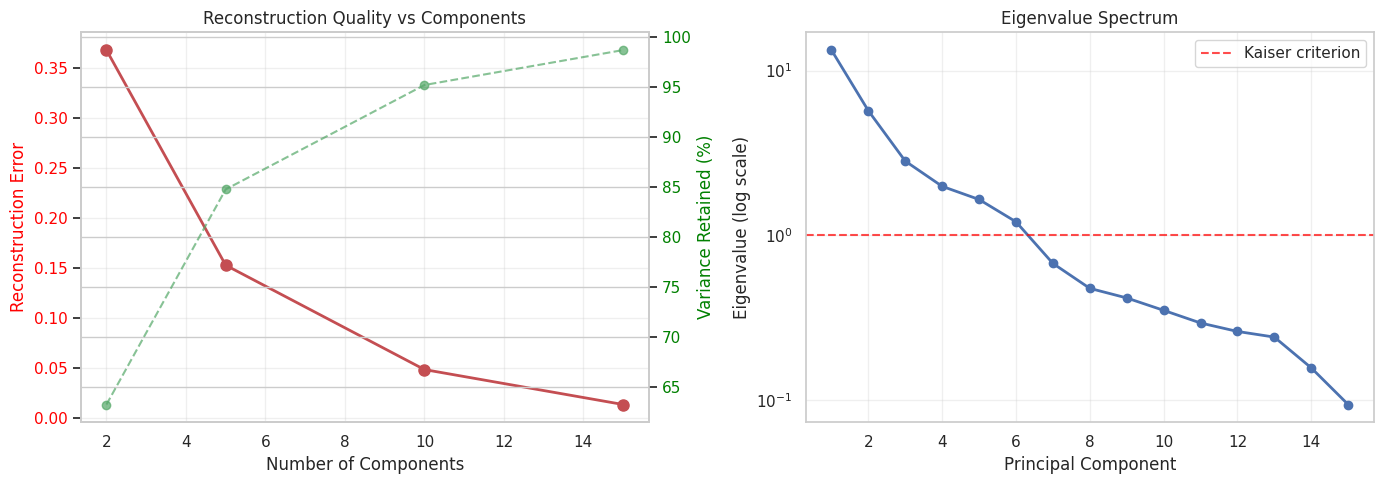

Quality plots show:
- Trade-off between reconstruction error and dimensionality
- Eigenvalue spectrum decay pattern
- Kaiser criterion threshold visualization
Dual-axis plot shows reconstruction vs. variance trade-off
Eigenvalue spectrum helps identify natural component cutoffs


In [ ]:
def visualize_quality_metrics(quality_metrics, pca_results):
    """Visualize reconstruction quality and eigenvalue spectrum."""
    print("\nCreating quality assessment plots...")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Reconstruction error vs components
    components = list(quality_metrics.keys())
    errors = [quality_metrics[k]['reconstruction_error'] for k in components]
    variances = [quality_metrics[k]['variance_retained'] for k in components]

    ax1.plot(components, errors, 'ro-', linewidth=2, markersize=8, label='Reconstruction Error')
    ax1.set_xlabel('Number of Components')
    ax1.set_ylabel('Reconstruction Error', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.grid(True, alpha=0.3)

    # Secondary y-axis for variance
    ax1_twin = ax1.twinx()
    ax1_twin.plot(components, [v*100 for v in variances], 'go--', alpha=0.7, label='Variance Retained (%)')
    ax1_twin.set_ylabel('Variance Retained (%)', color='green')
    ax1_twin.tick_params(axis='y', labelcolor='green')

    ax1.set_title('Reconstruction Quality vs Components')

    # Plot 2: Eigenvalue spectrum
    eigenvalues = pca_results['eigenvalues']
    ax2.semilogy(range(1, len(eigenvalues[:15]) + 1), eigenvalues[:15], 'bo-', linewidth=2, markersize=6)
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Kaiser criterion')
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Eigenvalue (log scale)')
    ax2.set_title('Eigenvalue Spectrum')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"Quality plots show:")
    print(f"- Trade-off between reconstruction error and dimensionality")
    print(f"- Eigenvalue spectrum decay pattern")
    print(f"- Kaiser criterion threshold visualization")

print("\n" + "=" * 60)
print("QUALITY METRICS VISUALIZATION")
print("=" * 60)

# Create quality assessment visualizations
visualize_quality_metrics(quality_metrics, pca_results)

print(f"Dual-axis plot shows reconstruction vs. variance trade-off")
print(f"Eigenvalue spectrum helps identify natural component cutoffs")

Compare original vs reconstructed individual samples to verify quality at individual data point level


**NOTE:** Reconstruction works by multiplying PCA scores with eigenvector transpose to estimate original 30 features from reduced components. More components = better reconstruction accuracy since we have more information to reverse the transformation.


Here, we plot for three random samples (patients)


INDIVIDUAL SAMPLE RECONSTRUCTION

Reconstruction Quality for Individual Samples:


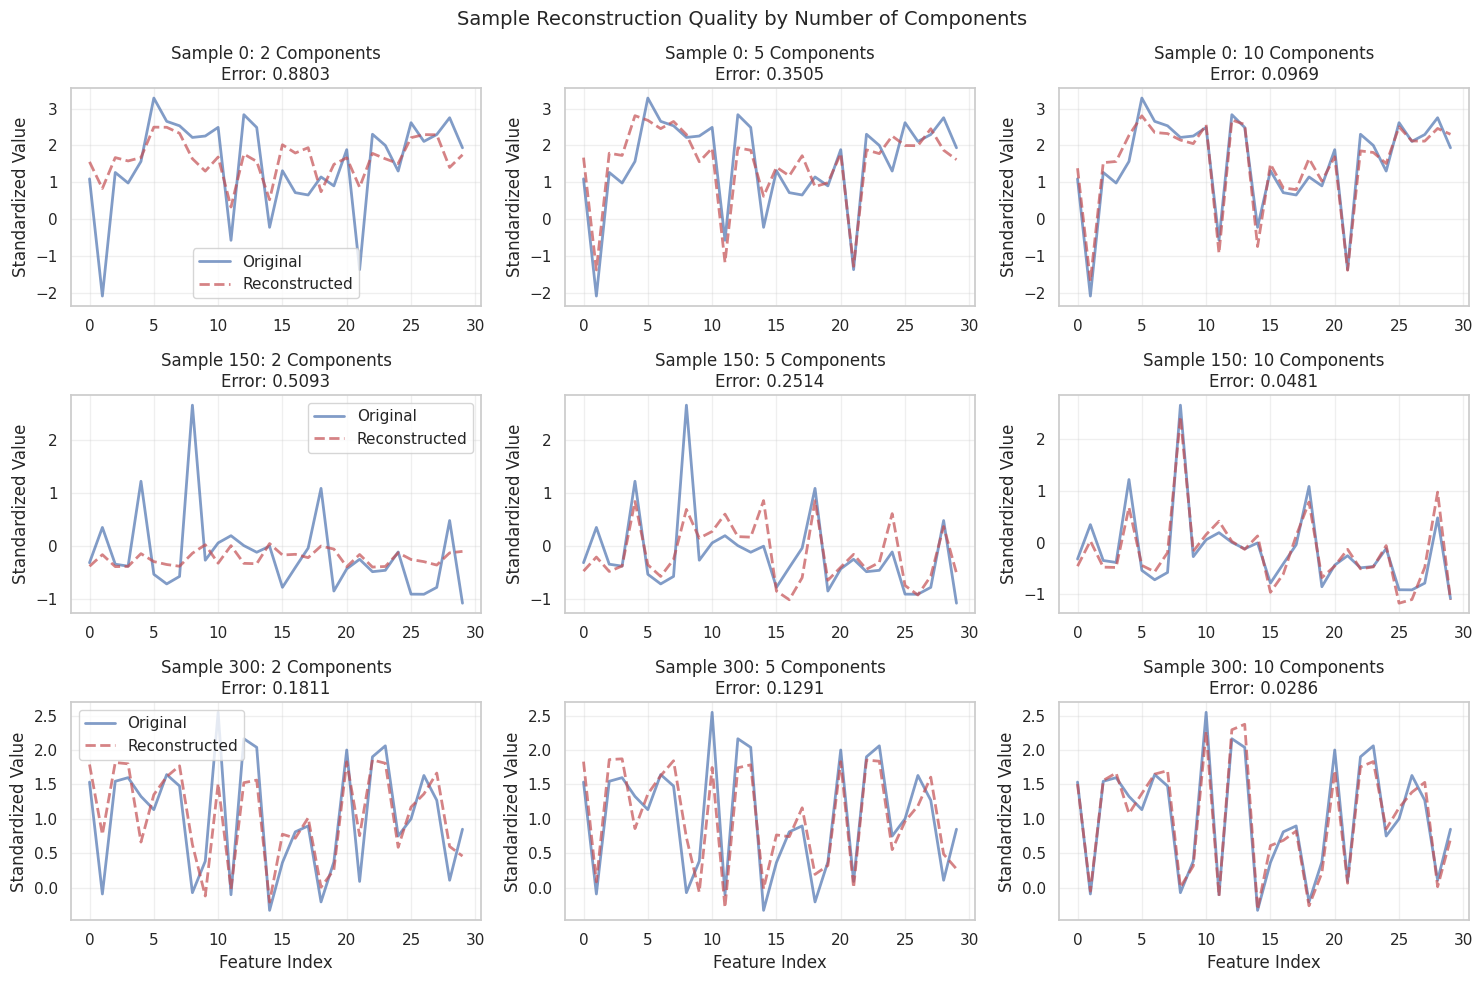

Shows how well PCA reconstructs individual data points
Blue lines = original data, Red dashed = reconstructed
Lower reconstruction error = better approximation


In [ ]:
def compare_reconstruction_samples(X_scaled, pca_results, feature_names, sample_indices=[0, 100, 200]):
    """Compare original vs reconstructed data for specific samples."""
    print(f"\nReconstruction Quality for Individual Samples:")

    eigenvectors = pca_results['eigenvectors']
    n_components_test = [2, 5, 10]

    fig, axes = plt.subplots(len(sample_indices), len(n_components_test), figsize=(15, 10))
    fig.suptitle('Sample Reconstruction Quality by Number of Components', fontsize=14)

    reconstruction_errors = {}

    for i, sample_idx in enumerate(sample_indices):
        original_sample = X_scaled[sample_idx]
        reconstruction_errors[sample_idx] = {}

        for j, n_comp in enumerate(n_components_test):
            # Reconstruct sample
            eigenvectors_subset = eigenvectors[:, :n_comp]
            sample_projected = original_sample @ eigenvectors_subset
            sample_reconstructed = sample_projected @ eigenvectors_subset.T

            reconstruction_error = np.mean((original_sample - sample_reconstructed) ** 2)
            reconstruction_errors[sample_idx][n_comp] = reconstruction_error

            if len(sample_indices) == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]

            x_pos = np.arange(len(feature_names))
            ax.plot(x_pos, original_sample, 'b-', alpha=0.7, label='Original', linewidth=2)
            ax.plot(x_pos, sample_reconstructed, 'r--', alpha=0.7, label='Reconstructed', linewidth=2)

            ax.set_title(f'Sample {sample_idx}: {n_comp} Components\nError: {reconstruction_error:.4f}')
            ax.set_ylabel('Standardized Value')
            if i == len(sample_indices) - 1:
                ax.set_xlabel('Feature Index')
            if j == 0:
                ax.legend()
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return reconstruction_errors

print("\n" + "=" * 60)
print("INDIVIDUAL SAMPLE RECONSTRUCTION")
print("=" * 60)

# Compare reconstruction quality for specific samples
reconstruction_errors = compare_reconstruction_samples(X_scaled, pca_results, feature_names,
                                                     sample_indices=[0, 150, 300])

print(f"Shows how well PCA reconstructs individual data points")
print(f"Blue lines = original data, Red dashed = reconstructed")
print(f"Lower reconstruction error = better approximation")

# 4: PCA + Machine Learning Classification Mini-Project

## Learning Objectives
- Apply PCA in a proper machine learning pipeline
- Classify breast cancer using only 2 principal components
- Compare supervised vs unsupervised learning approaches
- Visualize decision boundaries in 2D PCA space

## Proper ML Pipeline with PCA

### Critical Order of Operations
1. **Split data FIRST** (before any preprocessing)
2. **Fit scaler on training data only** (prevent data leakage)
3. **Transform test data using same scaler**
4. **Fit PCA on training data only** (prevent data leakage)
5. **Transform test data using same PCA**

### Why This Order Matters
- **Data leakage prevention**: Test data information doesn't influence preprocessing
- **Real-world simulation**: Mimics production environment where you only have training data
- **Reliable evaluation**: Ensures honest performance estimates

## Two Classification Approaches

### Method 1: K-Means Clustering (Unsupervised)
- **No labels used**: Discovers natural groupings in 2D PCA space
- **2 clusters**: Automatically finds cancer type groups
- **Label alignment**: Match discovered clusters to actual cancer types
- **Advantage**: Works without knowing true labels

### Method 2: SVM Classification (Supervised)
- **Uses labels**: Learns from known cancer type examples
- **RBF kernel**: Handles non-linear decision boundaries
- **Training on 2D**: Only uses PC1 and PC2 for classification
- **Advantage**: Optimized for known classification task

## Visualization Techniques

### 2D Scatter Plots
- **PC1 vs PC2**: Shows class separation in reduced space
- **Color coding**: Red (malignant) vs Blue (benign)
- **Training/Test split**: Verify consistent patterns across both sets

### Decision Boundaries
- **Mesh grid**: Creates dense prediction surface
- **Color regions**: Shows where each method predicts each class
- **Data overlay**: Original points on top of decision regions
- **Method comparison**: Visual difference between K-means and SVM

### Confusion Matrices
- **True vs Predicted**: Shows classification accuracy breakdown
- **Error analysis**: Identifies which cancer types are misclassified
- **Method comparison**: Side-by-side performance evaluation


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

print("PCA + Machine Learning Classification Mini-Project")
print("Goal: Classify breast cancer using only the first 2 principal components")
print("-" * 65)

# Reload data for mini-project (can skip if continuing from previous parts)
if 'X' not in globals():
    breast_cancer = load_breast_cancer()
    X = breast_cancer.data
    y = breast_cancer.target
    feature_names = breast_cancer.feature_names
    target_names = breast_cancer.target_names

print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Classes: {target_names[0]} (0), {target_names[1]} (1)")
print(f"Mini-project ready to begin!")

PCA + Machine Learning Classification Mini-Project
Goal: Classify breast cancer using only the first 2 principal components
-----------------------------------------------------------------
Dataset: 569 samples, 30 features
Classes: malignant (0), benign (1)
Mini-project ready to begin!


Define proper ML pipeline (train/test split → standardize → PCA)

In [ ]:
def prepare_data_with_pca(X, y, n_components=2):
    """
    Prepare data using proper ML pipeline with PCA.
    Key principle: Split FIRST, then fit preprocessing on training data only.
    """
    print(f"\nStep 1: Train/Test Split (BEFORE any preprocessing)")
    # Split data first to avoid data leakage
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    print(f"Training: {X_train.shape[0]} samples, Testing: {X_test.shape[0]} samples")

    print(f"\nStep 2: Standardize features (fit on training only)")
    # Fit scaler on training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # Use same scaler for test
    print(" Features standardized (mean=0, std=1)")

    print(f"\nStep 3: Apply PCA (fit on training only)")
    # Fit PCA on training data only
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)  # Use same PCA for test

    print(f" Reduced to {n_components} components")
    print(f" Variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")
    print(f"  - PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
    print(f"  - PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")

    return X_train_pca, X_test_pca, y_train, y_test, pca

print("\n" + "=" * 60)
print("PROPER ML PIPELINE WITH PCA")
print("=" * 60)

# Prepare data using proper ML pipeline (no data leakage!)
X_train_pca, X_test_pca, y_train, y_test, pca = prepare_data_with_pca(X, y, n_components=2)

print(f"Reduced from {X.shape[1]} features to 2 PCA components")



PROPER ML PIPELINE WITH PCA

Step 1: Train/Test Split (BEFORE any preprocessing)
Training: 398 samples, Testing: 171 samples

Step 2: Standardize features (fit on training only)
 Features standardized (mean=0, std=1)

Step 3: Apply PCA (fit on training only)
 Reduced to 2 components
 Variance explained: 64.8%
  - PC1: 45.2%
  - PC2: 19.6%
Reduced from 30 features to 2 PCA components


See class separation in 2D PCA space


VISUALIZE 2D PCA DATA

Visualizing 2D PCA projection...


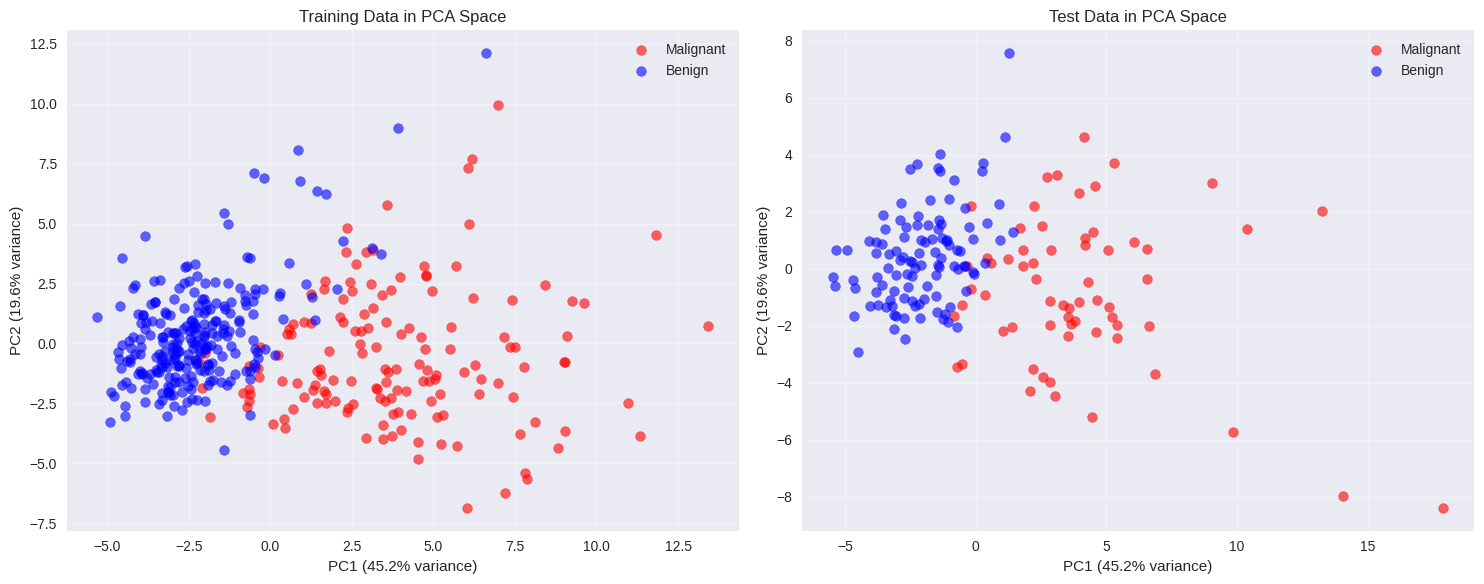

 Clear visual separation between classes in 2D PCA space
 Training and test data show similar patterns
 Classes are well-separated in 2D PCA space
 PC1 appears to be the primary discriminating axis


In [ ]:
def visualize_pca_data(X_train_pca, X_test_pca, y_train, y_test, pca):
    """Visualize the 2D PCA data and class separation."""
    print(f"\nVisualizing 2D PCA projection...")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Training data
    colors = ['red', 'blue']
    labels = ['Malignant', 'Benign']

    for i, (color, label) in enumerate(zip(colors, labels)):
        mask = y_train == i
        axes[0].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1],
                       c=color, alpha=0.6, s=50, label=label)

    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    axes[0].set_title('Training Data in PCA Space')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Test data
    for i, (color, label) in enumerate(zip(colors, labels)):
        mask = y_test == i
        axes[1].scatter(X_test_pca[mask, 0], X_test_pca[mask, 1],
                       c=color, alpha=0.6, s=50, label=label)

    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    axes[1].set_title('Test Data in PCA Space')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(" Clear visual separation between classes in 2D PCA space")

    return fig

print("\n" + "=" * 60)
print("VISUALIZE 2D PCA DATA")
print("=" * 60)

# Visualize the PCA-transformed data
fig = visualize_pca_data(X_train_pca, X_test_pca, y_train, y_test, pca)


print(f" Training and test data show similar patterns")
print(f" Classes are well-separated in 2D PCA space")
print(f" PC1 appears to be the primary discriminating axis")

Execute K-Means clustering - classify cancer using only cluster analysis

In [ ]:
def apply_kmeans_clustering(X_train_pca, X_test_pca, y_train, y_test):
    """Apply K-Means clustering and evaluate performance."""
    print(f"\nMethod 1: K-Means Clustering (Unsupervised)")

    # Fit K-means on training data
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    train_clusters = kmeans.fit_predict(X_train_pca)
    test_clusters = kmeans.predict(X_test_pca)

    # K-means labels might be flipped, so we need to align them
    # Check which cluster corresponds to which class
    from scipy.stats import mode

    # Find the most common true label for each cluster in training
    cluster_0_labels = y_train[train_clusters == 0]
    cluster_1_labels = y_train[train_clusters == 1]

    cluster_0_mode = mode(cluster_0_labels, keepdims=False)[0] if len(cluster_0_labels) > 0 else 0
    cluster_1_mode = mode(cluster_1_labels, keepdims=False)[0] if len(cluster_1_labels) > 0 else 1

    # Create mapping
    if cluster_0_mode == 0:  # cluster 0 is malignant
        test_pred = test_clusters
    else:  # flip the labels
        test_pred = 1 - test_clusters

    accuracy = accuracy_score(y_test, test_pred)
    print(f"K-Means Accuracy: {accuracy:.3f}")
    print(f" Unsupervised method achieves {accuracy*100:.1f}% accuracy!")

    return test_pred, kmeans

print("\n" + "=" * 60)
print("K-MEANS CLUSTERING (UNSUPERVISED)")
print("=" * 60)

# Apply K-Means clustering
kmeans_pred, kmeans_model = apply_kmeans_clustering(X_train_pca, X_test_pca, y_train, y_test)
kmeans_accuracy = accuracy_score(y_test, kmeans_pred)



K-MEANS CLUSTERING (UNSUPERVISED)

Method 1: K-Means Clustering (Unsupervised)
K-Means Accuracy: 0.924
 Unsupervised method achieves 92.4% accuracy!


Execute SVM classification - classify cancer using labeled training data

In [ ]:
def apply_svm_classification(X_train_pca, X_test_pca, y_train, y_test):
    """Apply SVM classification and evaluate performance."""
    print(f"\nMethod 2: SVM Classification (Supervised)")

    # Train SVM on 2D PCA data
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train_pca, y_train)

    # Predict on test data
    y_pred = svm.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"SVM Accuracy: {accuracy:.3f}")
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))

    return y_pred, svm

print("\n" + "=" * 60)
print("SVM CLASSIFICATION (SUPERVISED)")
print("=" * 60)

# Apply SVM classification
svm_pred, svm_model = apply_svm_classification(X_train_pca, X_test_pca, y_train, y_test)
svm_accuracy = accuracy_score(y_test, svm_pred)


print(f" Achieved {svm_accuracy*100:.1f}% accuracy")



SVM CLASSIFICATION (SUPERVISED)

Method 2: SVM Classification (Supervised)
SVM Accuracy: 0.959

Detailed Classification Report:
              precision    recall  f1-score   support

   Malignant       0.97      0.92      0.94        64
      Benign       0.95      0.98      0.97       107

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171

 Achieved 95.9% accuracy


Visually compare K-Means vs SVM separation


Creating  decision boundary visualization...


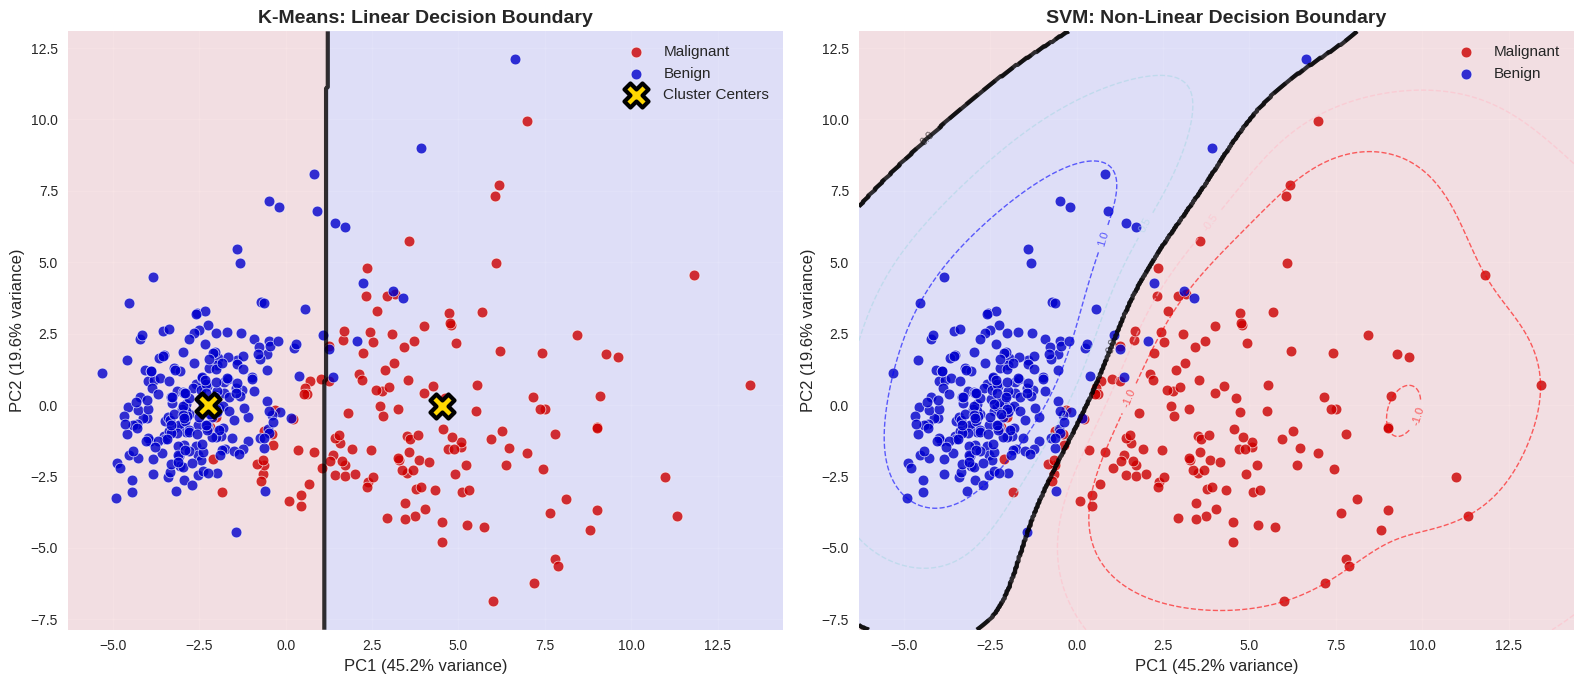


Decision Boundary Analysis:
BLACK SOLID LINE = Decision boundary (where classification changes)
K-Means: Straight line boundary based on distance to cluster centers
SVM: Curved boundary that maximizes margin between classes
Dashed lines in SVM plot show confidence levels


In [ ]:
def visualize_decision_boundaries(X_train_pca, y_train, kmeans, svm, pca):
    """Visualize decision boundaries."""
    print(f"\nCreating  decision boundary visualization...")

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Create a finer mesh for smoother boundaries
    h = 0.05  # Smaller step size for smoother boundaries
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    mesh_points = np.c_[xx.ravel(), yy.ravel()]

    # Plot 1: K-Means
    Z_kmeans = kmeans.predict(mesh_points)
    Z_kmeans = Z_kmeans.reshape(xx.shape)

    # Use contour lines for clearer boundaries
    axes[0].contour(xx, yy, Z_kmeans, levels=[0.5], colors=['black'], linewidths=3, alpha=0.8)
    axes[0].contourf(xx, yy, Z_kmeans, levels=[0, 0.5, 1], colors=['#ffcccc', '#ccccff'], alpha=0.4)

    # Plot data points
    colors = ['#cc0000', '#0000cc']  # Darker colors
    labels = ['Malignant', 'Benign']
    for i, (color, label) in enumerate(zip(colors, labels)):
        mask = y_train == i
        axes[0].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1],
                       c=color, alpha=0.8, s=60, label=label, edgecolors='white', linewidth=0.5)

    # Plot cluster centers
    centers = kmeans.cluster_centers_
    axes[0].scatter(centers[:, 0], centers[:, 1], c='gold', marker='X', s=300,
                   linewidths=3, edgecolors='black', label='Cluster Centers')

    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
    axes[0].set_title('K-Means: Linear Decision Boundary', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Plot 2: SVM
    Z_svm = svm.predict(mesh_points)
    Z_svm = Z_svm.reshape(xx.shape)

    # SVM decision boundary with multiple contour levels for better visualization
    axes[1].contour(xx, yy, Z_svm, levels=[0.5], colors=['black'], linewidths=3, alpha=0.8)
    axes[1].contourf(xx, yy, Z_svm, levels=[0, 0.5, 1], colors=['#ffcccc', '#ccccff'], alpha=0.4)

    # If SVM has decision_function, show confidence regions
    try:
        Z_svm_confidence = svm.decision_function(mesh_points)
        Z_svm_confidence = Z_svm_confidence.reshape(xx.shape)

        # Add confidence contours
        confidence_levels = [-1, -0.5, 0, 0.5, 1]
        contour_set = axes[1].contour(xx, yy, Z_svm_confidence, levels=confidence_levels,
                                     colors=['red', 'pink', 'black', 'lightblue', 'blue'],
                                     linewidths=[1, 1, 3, 1, 1], alpha=0.6, linestyles='--')
        axes[1].clabel(contour_set, inline=True, fontsize=8, fmt='%0.1f')
    except:
        pass  # If decision_function not available, skip confidence regions

    # Plot data points
    for i, (color, label) in enumerate(zip(colors, labels)):
        mask = y_train == i
        axes[1].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1],
                       c=color, alpha=0.8, s=60, label=label, edgecolors='white', linewidth=0.5)

    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
    axes[1].set_title('SVM: Non-Linear Decision Boundary', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print interpretation
    print("\nDecision Boundary Analysis:")
    print("BLACK SOLID LINE = Decision boundary (where classification changes)")
    print("K-Means: Straight line boundary based on distance to cluster centers")
    print("SVM: Curved boundary that maximizes margin between classes")

    if 'contour_set' in locals():
        print("Dashed lines in SVM plot show confidence levels")

    return fig


boundary_fig = visualize_decision_boundaries(X_train_pca, y_train, kmeans_model, svm_model, pca)

Confusion matrix  - see true vs predicted classifications


CONFUSION MATRIX ANALYSIS

Confusion Matrices:


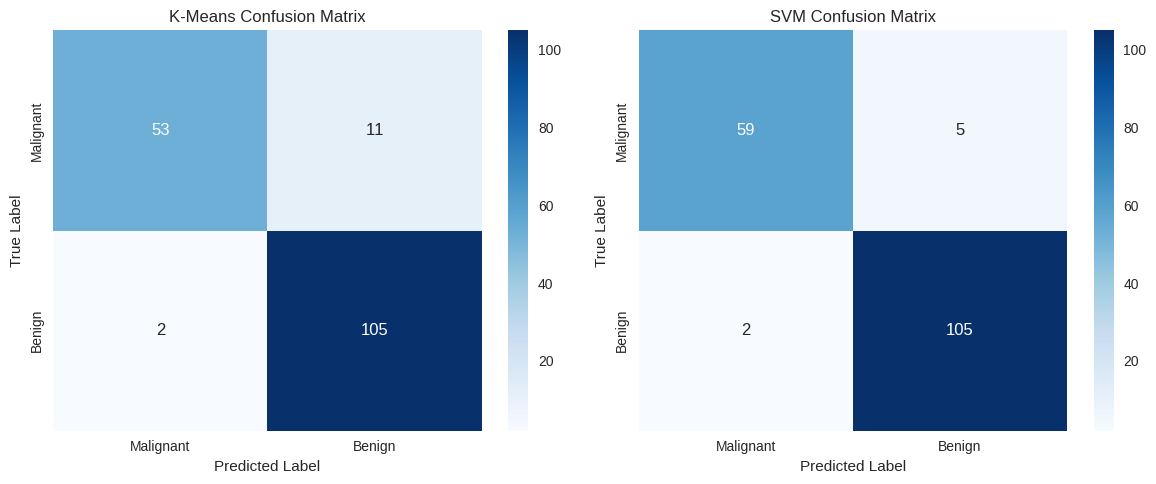


Detailed Performance Metrics:
K-Means - True Positives: 105, False Positives: 11
K-Means - True Negatives: 53, False Negatives: 2
SVM - True Positives: 105, False Positives: 5
SVM - True Negatives: 59, False Negatives: 2


In [ ]:
def create_confusion_matrices(y_test, kmeans_pred, svm_pred):
    """Create confusion matrices for both methods."""
    print(f"\nConfusion Matrices:")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # K-Means confusion matrix
    cm_kmeans = confusion_matrix(y_test, kmeans_pred)
    sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Malignant', 'Benign'],
                yticklabels=['Malignant', 'Benign'], ax=axes[0])
    axes[0].set_title('K-Means Confusion Matrix')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # SVM confusion matrix
    cm_svm = confusion_matrix(y_test, svm_pred)
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Malignant', 'Benign'],
                yticklabels=['Malignant', 'Benign'], ax=axes[1])
    axes[1].set_title('SVM Confusion Matrix')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

    return cm_kmeans, cm_svm

print("\n" + "=" * 60)
print("CONFUSION MATRIX ANALYSIS")
print("=" * 60)

# Create confusion matrices for detailed performance analysis
cm_kmeans, cm_svm = create_confusion_matrices(y_test, kmeans_pred, svm_pred)


# Calculate additional metrics
print(f"\nDetailed Performance Metrics:")
print(f"K-Means - True Positives: {cm_kmeans[1,1]}, False Positives: {cm_kmeans[0,1]}")
print(f"K-Means - True Negatives: {cm_kmeans[0,0]}, False Negatives: {cm_kmeans[1,0]}")
print(f"SVM - True Positives: {cm_svm[1,1]}, False Positives: {cm_svm[0,1]}")
print(f"SVM - True Negatives: {cm_svm[0,0]}, False Negatives: {cm_svm[1,0]}")

Final summary

In [ ]:
def summarize_results(kmeans_accuracy, svm_accuracy, pca):
    """Summarize the mini-project results in a clean table."""
    import pandas as pd

    # Create summary table
    results_data = {
        'Metric': [
            'Original Features',
            'PCA Components',
            'Dimensionality Reduction',
            'Variance Retained',
            'K-Means Accuracy',
            'SVM Accuracy'
        ],
        'Value': [
            '30',
            '2',
            f'{30/2:.1f}x',
            f'{sum(pca.explained_variance_ratio_)*100:.1f}%',
            f'{kmeans_accuracy:.3f}',
            f'{svm_accuracy:.3f}'
        ]
    }

    results_df = pd.DataFrame(results_data)
    print("\nMINI-PROJECT RESULTS")
    print("=" * 25)
    print(results_df.to_string(index=False))

    return {
        'data_reduction': 30/2,
        'variance_retained': sum(pca.explained_variance_ratio_),
        'kmeans_accuracy': kmeans_accuracy,
        'svm_accuracy': svm_accuracy
    }

print("\n" + "=" * 60)
print("FINAL RESULTS")
print("=" * 60)

# Summarize all results in clean table
final_results = summarize_results(kmeans_accuracy, svm_accuracy, pca)



FINAL RESULTS

MINI-PROJECT RESULTS
                  Metric Value
       Original Features    30
          PCA Components     2
Dimensionality Reduction 15.0x
       Variance Retained 64.8%
        K-Means Accuracy 0.924
            SVM Accuracy 0.959
